In [1]:
import numpy as np
import matplotlib.pyplot as plt
from image_processing import img_to_array, get_patch_params, extract_patches
from spectral_clustering import compute_kernel_matrix, compute_laplacian, k_smallest_eig, img_spectral_clustering
from visualization import plot_image, plot_graph_node_degrees, plot_eigen_values, plot_eigen_vectors_images, plot_clustering_results
from PIL import Image
from sklearn.cluster import KMeans

# Loading the image

We convert the original image to grayscale, and use it as a numpy array for the following code

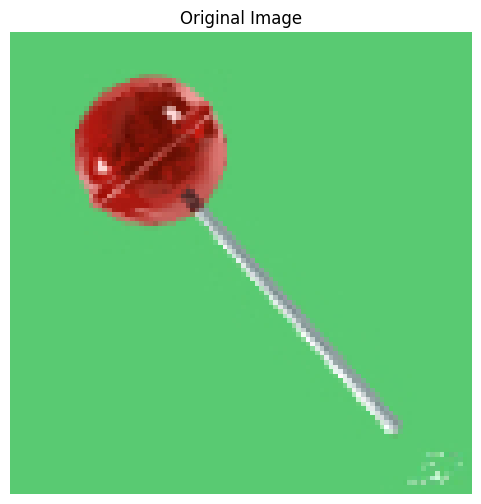

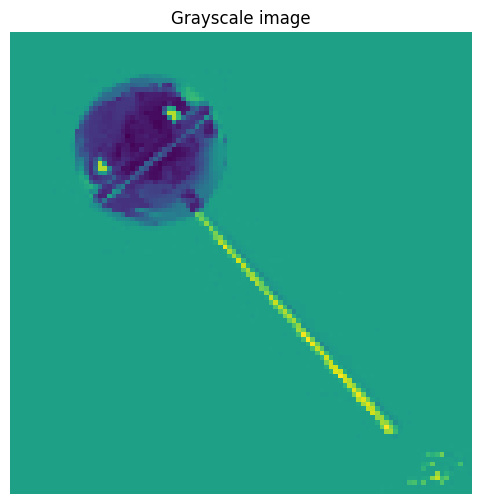

In [2]:
# Load and preprocess the image
img_path = "images/lolipop_img.jpg"
img = Image.open(img_path)
img_array = img_to_array(img)

plot_image(img, "Original Image")
plot_image(img_array, "Grayscale image")

# Using img_spectral_clustering function

Extracting image patches...
Computing kernel matrix...
Extracting eigen vectors for spectral embedding...
Clustering...


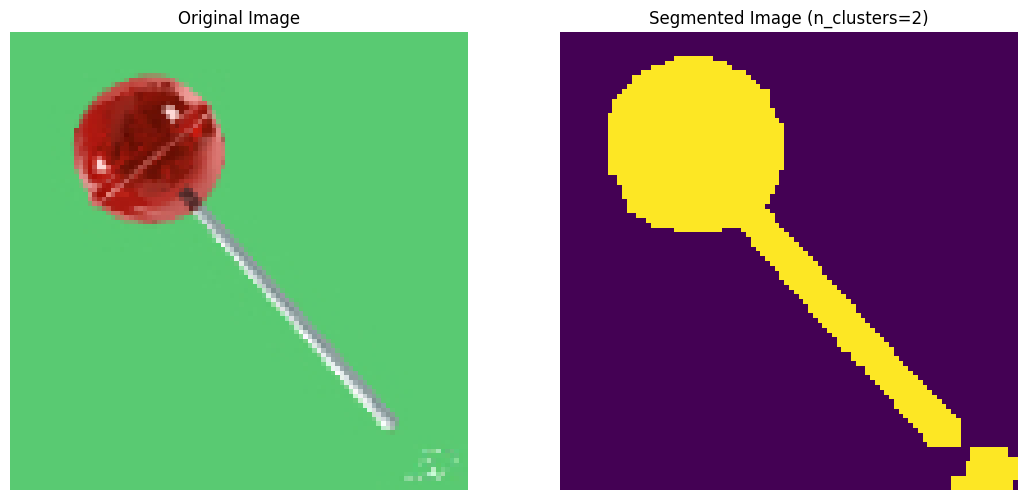

In [3]:
segmented_img_array = img_spectral_clustering(img_array, n_clusters=2)
plot_clustering_results(img, segmented_img_array, n_clusters=2)

`n_clusters` parameter determines the amount of segments. In this example, the lolipop and the background are divided to $2$ clusters.

# Customizing model parameters

In some cases, it is needed to tune parameters in order to achieve a good result. For example, we will load this image

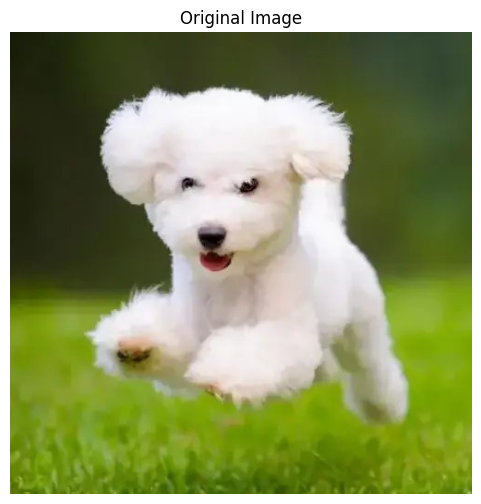

In [4]:
# Load and preprocess the image
img_path = "images/dog_img.jpg"
img = Image.open(img_path)
img_array = img_to_array(img)

plot_image(img, "Original Image")

Extracting image patches...
Computing kernel matrix...
Extracting eigen vectors for spectral embedding...
Clustering...


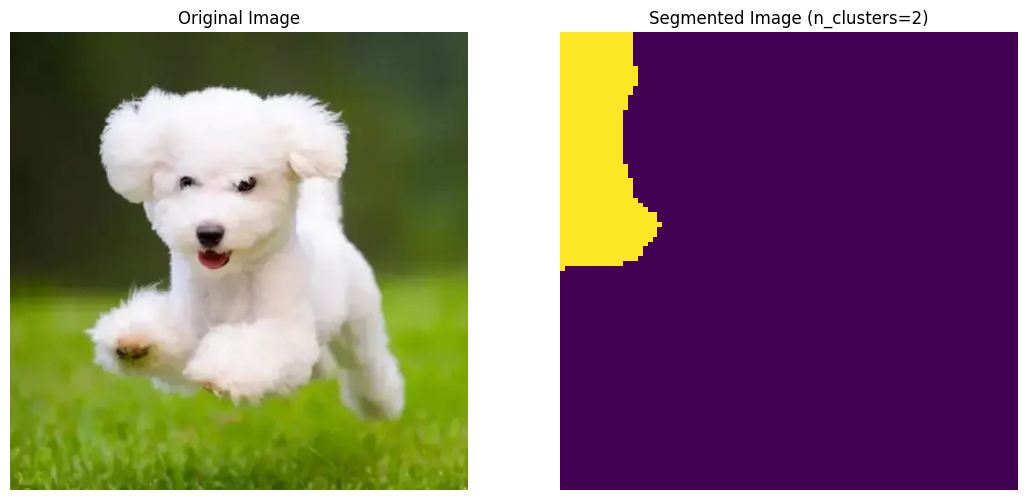

In [5]:
segmented_img_array = img_spectral_clustering(img_array, n_clusters=2)
plot_clustering_results(img, segmented_img_array, n_clusters=2)

It didn't work quite well.

### Image patches

We will use here `get_patch_params` function to extract the parameters, but custom parameters can also be passed to `extract_patches` function. For custom parameters, it is not guaranteed that every pixel in the image will be extracted to a patch.

In [6]:
# Get patch params
n = img_array.shape[0]
patch_size, patch_gap = get_patch_params(n)
print(f"Patch dimensions: {(patch_size, patch_size)}\nPixel gap between patches: {patch_gap}")

# Extract patches
patches = extract_patches(img_array, patch_size, patch_gap)
n_patches = len(patches)
print(f"The total number of patches extracted: {n_patches}")

# Create the matrix X where each feature is a pixel of a patch
X = patches.reshape(n_patches, patch_size**2)

Patch dimensions: (35, 35)
Pixel gap between patches: 5
The total number of patches extracted: 8836


### Kernel/graph representation

Here we create the matrix $K\in\mathbb{R}^{\text{n\_patches}\times\text{n\_patches}}$, which is the adjacency matrix of the graph where each patch represents a node. Higher values of `k_neighbors` will lead to a more connected graph.

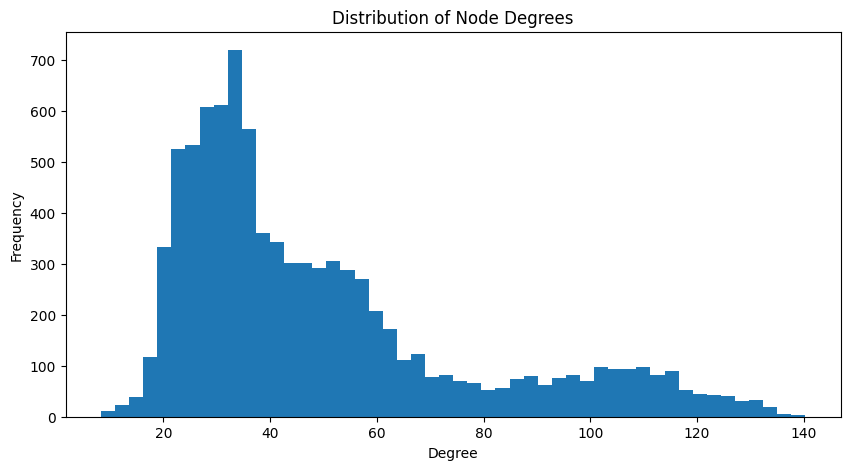

In [8]:
K = compute_kernel_matrix(X, k_neighbors=20)
plot_graph_node_degrees(K)

### Spectral embedding

We compute the normalized Laplacian matrix $L=I-D^{-1/2}KD^{-1/2}$ and extract the `k`=4 smallest eigen values and their corresponding vectors from it. `skip_first` ignors the trivial $0$ eigen value of $L$. 

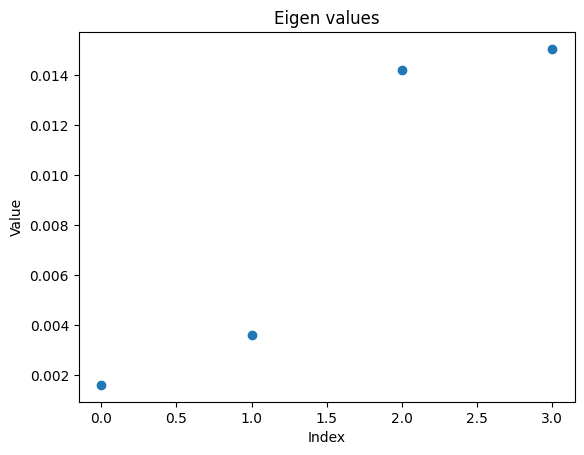

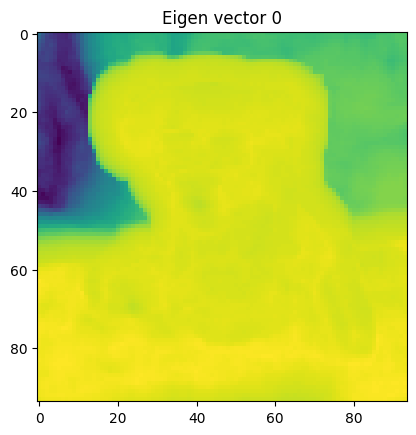

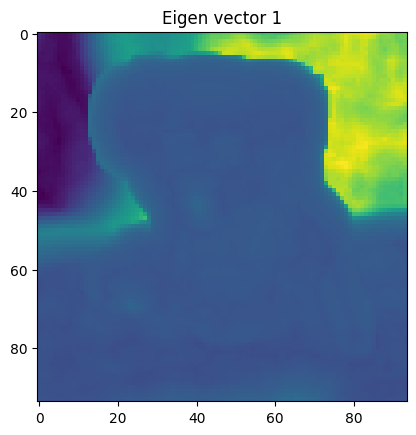

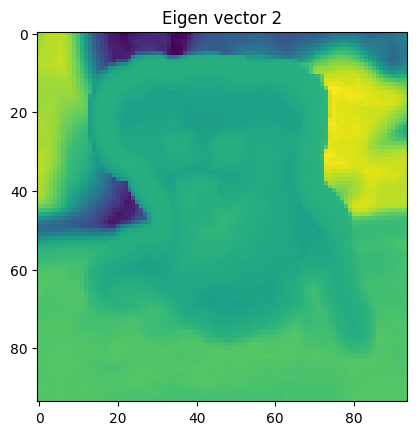

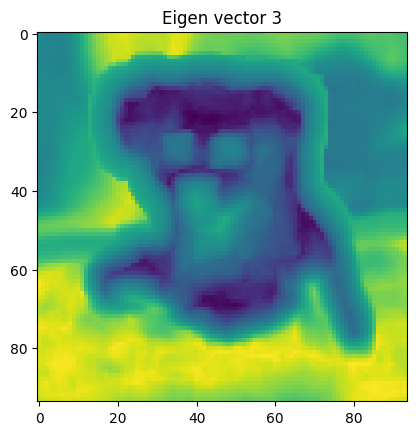

In [9]:
L = compute_laplacian(K)
eig_values, eig_vectors = k_smallest_eig(L, k=4, skip_first=True)
plot_eigen_values(eig_values)
plot_eigen_vectors_images(eig_vectors)

Notice that eigen vector $3$ seems to have an important role in capturing the dog shape.

### Clustering

Finally, we will apply a clustering algorithm (we use *KMeans*) over the spectral embedding matrix $U$. We will choose different combinations of eigen vectors to build $U$, in order to show the differences in segmentation results

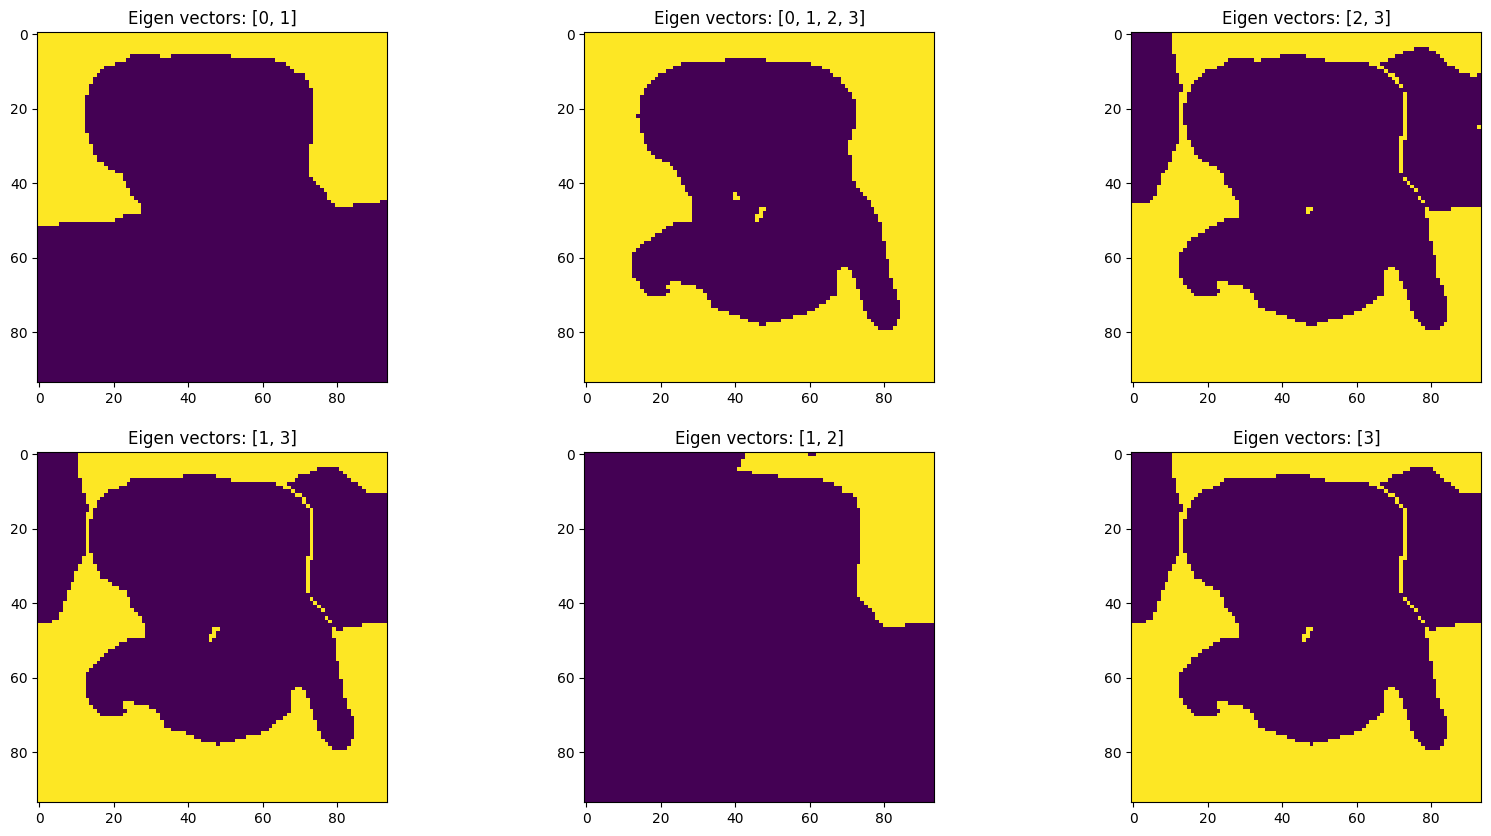

In [10]:
# Index combinations for eigen vectors
combs = [[0,1], [1,2], [2,3], [1,3], [0,1,2,3], [3]]

fig, axs = plt.subplots(2, 3, figsize=(20,10))
for i, indices in enumerate(combs):
    # Cluster over U
    U = eig_vectors[:, indices]
    kmeans = KMeans(n_clusters=2, random_state=41)
    kmeans.fit(U)
    cluster_labels = kmeans.labels_

    # Reshape and plot segmented image
    reshaped_dim = np.sqrt(len(cluster_labels)).astype(int)
    segmented_img_array = np.reshape(cluster_labels, (reshaped_dim, reshaped_dim))
    axs[i%2, i%3].imshow(segmented_img_array)
    axs[i%2, i%3].set_title(f"Eigen vectors: {indices}")
plt.show()

In this case, using all $4$ eigen vectors ([0,1,2,3]) to build $U$ while using $\text{n\_clusters}=2$ gave the best results